# Company X Data Science Take Home

## Objective

Using the two attached datasets, vehicles and reservations, determine:
- Which factors seem to be most important in driving total # of reservations for our vehicles? (use a model to drive your insights)
- How does the car's technology type seem to affect reservations?

## Table of Contents

1. [Explore the vehicles dataset](#explore_vehicles)
2. [Explore the reservations dataset](#explore_res)
3. [Merge and explore the vehicles and reservations datasets](#merge_data)
4. [Which factors increase the chances of reserving a vehicle?](#chance_reserve_vehicle)
5. [Investigate most important factors for reservation type 1: Hourly rental](#hourly)<br/>
    i. [What is SHAP???](#shap)
6. [Investigate most important factors for reservation type 2: Daily rental](#daily)
7. [Investigate most important factors for reservation type 3: Weekly rental](#weekly)
8. [Conclusions, Part I: Which factors seem to be most important in driving total # of reservations for our vehicles?](#part1)
9. [Conclusions, Part II: How does the car's technology type seem to affect reservations?](#part2)
10. [Next Steps](#next)
11. [Appendix](#appendix)

In [1]:
# Import required libraries
from IPython.display import display, HTML

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_validate

import shap

# Initialize SHAP js visualizations
shap.initjs()

# Set seed for repeatability of results
SEED = 42
np.random.seed(SEED)

## Explore the vehicles dataset
<a id="explore_vehicles"></a>

In [2]:
# Read in the vehicles dataset
vehicles_filename = 'vehicles.csv'
vehicles = pd.read_csv(vehicles_filename)

print(vehicles.info())
vehicles.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   vehicle_id         1000 non-null   int64  
 1   technology         1000 non-null   int64  
 2   actual_price       1000 non-null   float64
 3   recommended_price  1000 non-null   int64  
 4   num_images         1000 non-null   int64  
 5   street_parked      1000 non-null   int64  
 6   description        1000 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 54.8 KB
None


,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description
0,1,1,67.85,59,5,0,7
1,2,0,100.70,53,5,0,224
2,3,0,74.00,74,4,1,21
3,4,0,135.00,75,1,0,184
4,5,0,59.36,53,2,1,31


In [3]:
# Summary statistics
vehicles.describe()

,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,0.170000,87.940730,62.206000,3.008000,0.511000,90.792000
std,288.819436,0.375821,29.724589,16.082544,1.348983,0.500129,76.948644
min,1.000000,0.000000,32.760000,35.000000,1.000000,0.000000,1.000000
25%,250.750000,0.000000,64.942500,49.000000,2.000000,0.000000,25.000000
50%,500.500000,0.000000,83.930000,62.000000,3.000000,1.000000,57.500000
75%,750.250000,0.000000,107.010000,76.000000,4.000000,1.000000,158.000000
max,1000.000000,1.000000,174.440000,90.000000,5.000000,1.000000,250.000000


In [4]:
# Number of unique vehicles in the dataset
print("Number of unique vehicles: ", len(vehicles.vehicle_id.unique()))

Number of unique vehicles:  1000


- As we can see from the above results that there are no missing values in the vehicles dataset. 
- Each record in the vehicles dataset pertains to a unique vehicle.
- Additionally, we also notice that the _actual_price_ on average is higher than the _recommended_price_. Let us quickly check, how much higher is the _actual_price_ over the _recommended_price_.

In [5]:
# Determine avg. percentage of actual_price over recommended_price
act_rec_price_ratio = (vehicles.actual_price - vehicles.recommended_price) / vehicles.recommended_price * 100
act_rec_price_ratio.describe()

count    1000.000000
mean       41.502000
std        30.249877
min       -20.000000
25%        17.000000
50%        39.000000
75%        65.250000
max       100.000000
dtype: float64

We learn that the on average the _actual_price_ is 41.5% higher than the _recommended_price_. It will be interesting to analyze how this difference effects the total number of reservations.

## Explore the reservations dataset
<a id="explore_res"></a>

In [6]:
# Read in the reservations dataset
reservations_filename = 'reservations.csv'
reservations = pd.read_csv(reservations_filename)

print(reservations.info())
reservations.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6376 entries, 0 to 6375
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   vehicle_id        6376 non-null   int64
 1   reservation_type  6376 non-null   int64
dtypes: int64(2)
memory usage: 99.8 KB
None


,vehicle_id,reservation_type
0,208,1
1,601,3
2,993,1
3,423,2
4,685,3


The number of records in the reservations dataset is 6,376. This is over six times greater than the number of records in the vehicles dataset. This may imply that each vehicle has been reserved at least one time. But, let us verify if this statement is true.

In [7]:
vehicles_not_reserved = vehicles.loc[~vehicles.vehicle_id.isin(reservations.vehicle_id), 'vehicle_id']
print("Number of vehicles with no reservations: ", len(vehicles_not_reserved))
print("Sample vehicle ids with no reservations: ", vehicles_not_reserved[:5].values)

Number of vehicles with no reservations:  89
Sample vehicle ids with no reservations:  [ 7 13 33 45 86]


- We have identified 89 vehicles with no reservations.
- 911 vehicles from our vehicles dataset have been reserved.

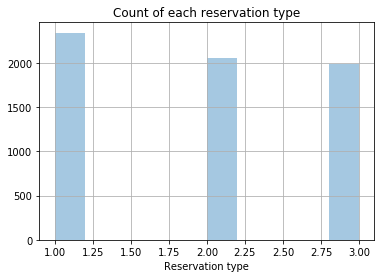

In [8]:
# Explore the distribution of the reservation types
fig, ax = plt.subplots()
reservations.reservation_type.hist(alpha=0.4, ax=ax)
plt.title('Count of each reservation type')
plt.xlabel('Reservation type')
plt.show()

The number of each reservation type does not differ significantly, the values are close to eachother.

As next steps, let us combine the vehicles and reservations datasets to further investigate the data with respect to whether a vehicle was reserved or not and the reservation types.

Now that we know not every vehicle in the vehicle dataset has been reserved, it is best to create a _reserved indicator_ column.

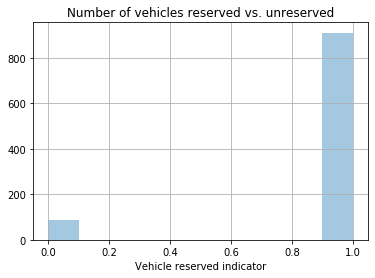

Percentage of vehicles reserved:  91.1 %


In [9]:
# Add a new column to the vehicles dataset: reserved_ind
vehicles['reserved_ind'] = 0
vehicles.loc[vehicles.vehicle_id.isin(reservations.vehicle_id), 'reserved_ind'] = 1

fig, ax = plt.subplots()
vehicles.reserved_ind.hist(alpha=0.4, ax=ax)
plt.title('Number of vehicles reserved vs. unreserved')
plt.xlabel('Vehicle reserved indicator')
plt.show()

print("Percentage of vehicles reserved: ", 
      round(vehicles.reserved_ind.mean()*100, 2), "%")

## Merge and explore the vehicles and reservations datasets
<a id="merge_data"></a>

Before merging the datasets let us investigate the number of each reservation type for each vehicle in the reservations dataset.

In [10]:
# Inspect the number of reservations per reservation type
reservations['dummy_col'] = 1  # assiging 1 to determine the count of each reservation 
                               # type for each vehicle
reservation_type_count = pd.pivot_table(reservations, index='vehicle_id', 
                                        columns='reservation_type', values='dummy_col', 
                                        aggfunc=np.sum)
reservation_type_count = reservation_type_count.add_prefix('reservation_type_')
reservation_type_count.columns.name = ''
reservation_type_count.reset_index(inplace=True)
reservation_type_count

,vehicle_id,reservation_type_1,reservation_type_2,reservation_type_3
0,1,1.0,NaN,NaN
1,2,4.0,3.0,NaN
2,3,1.0,9.0,7.0
3,4,1.0,NaN,1.0
4,5,NaN,1.0,1.0
...,...,...,...,...
906,996,4.0,10.0,5.0
907,997,5.0,1.0,3.0
908,998,3.0,2.0,1.0
909,999,1.0,1.0,7.0


In [11]:
reservation_type_count.describe()

,vehicle_id,reservation_type_1,reservation_type_2,reservation_type_3
count,911.000000,761.000000,760.000000,761.000000
mean,494.600439,3.073587,2.706579,2.601840
std,288.242005,2.115071,1.781018,1.702304
min,1.000000,1.000000,1.000000,1.000000
25%,245.500000,1.000000,1.000000,1.000000
50%,493.000000,3.000000,2.000000,2.000000
75%,739.500000,4.000000,4.000000,3.000000
max,1000.000000,14.000000,12.000000,12.000000


A few observations: 

* There are some vehicles that have been reserved either daily, weekly or hourly, and there are some vehicles that have some combination of the reservation types, example - hourly and daily or hourly and weekly.
* The mean number of reservations for each reservation type are approximately equal to each other.

In [12]:
# Merge the reservations and vehicles dataframes
vr_merged = pd.merge(vehicles, reservation_type_count, on='vehicle_id', how='left')
print(vr_merged.info())
vr_merged

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   vehicle_id          1000 non-null   int64  
 1   technology          1000 non-null   int64  
 2   actual_price        1000 non-null   float64
 3   recommended_price   1000 non-null   int64  
 4   num_images          1000 non-null   int64  
 5   street_parked       1000 non-null   int64  
 6   description         1000 non-null   int64  
 7   reserved_ind        1000 non-null   int64  
 8   reservation_type_1  761 non-null    float64
 9   reservation_type_2  760 non-null    float64
 10  reservation_type_3  761 non-null    float64
dtypes: float64(4), int64(7)
memory usage: 93.8 KB
None


,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description,reserved_ind,reservation_type_1,reservation_type_2,reservation_type_3
0,1,1,67.85,59,5,0,7,1,1.0,NaN,NaN
1,2,0,100.70,53,5,0,224,1,4.0,3.0,NaN
2,3,0,74.00,74,4,1,21,1,1.0,9.0,7.0
3,4,0,135.00,75,1,0,184,1,1.0,NaN,1.0
4,5,0,59.36,53,2,1,31,1,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
995,996,0,39.90,38,2,1,16,1,4.0,10.0,5.0
996,997,0,74.34,63,2,0,61,1,5.0,1.0,3.0
997,998,0,139.32,81,4,0,35,1,3.0,2.0,1.0
998,999,0,72.76,68,4,1,199,1,1.0,1.0,7.0


In [13]:
# Summary statistics of the merged dataframe
vr_merged.describe()

,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description,reserved_ind,reservation_type_1,reservation_type_2,reservation_type_3
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,761.000000,760.000000,761.000000
mean,500.500000,0.170000,87.940730,62.206000,3.008000,0.511000,90.792000,0.911000,3.073587,2.706579,2.601840
std,288.819436,0.375821,29.724589,16.082544,1.348983,0.500129,76.948644,0.284886,2.115071,1.781018,1.702304
min,1.000000,0.000000,32.760000,35.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,250.750000,0.000000,64.942500,49.000000,2.000000,0.000000,25.000000,1.000000,1.000000,1.000000,1.000000
50%,500.500000,0.000000,83.930000,62.000000,3.000000,1.000000,57.500000,1.000000,3.000000,2.000000,2.000000
75%,750.250000,0.000000,107.010000,76.000000,4.000000,1.000000,158.000000,1.000000,4.000000,4.000000,3.000000
max,1000.000000,1.000000,174.440000,90.000000,5.000000,1.000000,250.000000,1.000000,14.000000,12.000000,12.000000


## Which factors increase the chances of reserving a vehicle?
<a id="chance_reserve_vehicle"></a>

We want to answer which factors drive the number of total reservations of the vehicles; as our first step into the investigative process, are we able to identify if there are any factors that increase the likelihood of a vehicle being reserved?

**But why are we interested in determining which factors have an influence on the chances of reserving a vehicle?**<br/> 
Company X makes money from every single reservation made on its platform. If we are able to identify which factors have an influence, then, when a guest is searching for vehicles to rent, the search rank engine can accordingly rank the vehicles based on the likelihood of being reserved. This will drive significant revenue to Company X's business. 

My initial beliefs are (the following beliefs are based on how I would go about booking a vehicle):

* _actual_price_ is going to be my most important consideration when reserving a vehicle. As a guest, I want to minimize my cost.
* _num_images_ is going to be my second consideration when reserving a vehicle. If I am renting a vehicle from a non-car rental organization, I am going to be wary of the condition of the car. If I am able to see more images of the vehicle, I, the guest, will trust the host more and be less wary of renting a poor quality vehicle. 

Let's begin the investigation!

In [14]:
def plot_hists_col(col_nm, sup_title, bins=10):
    """Function to plot histograms of a column with respect to
    whether to the vehicle reservation indicator"""
    
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(14, 5)

    vr_merged.loc[vr_merged.reserved_ind == 1, col_nm].hist(
        bins=bins, alpha=0.4, color='g', label='reserved', ax=ax[0])
    vr_merged.loc[vr_merged.reserved_ind == 0, col_nm].hist(
        bins=bins, alpha=0.3, color='r', label='unreserved', ax=ax[0])
    # ax[0].xlabel('technology')
    ax[0].title.set_text('Histogram')
    ax[0].legend()

    vr_merged.loc[vr_merged.reserved_ind == 1, col_nm].hist(
        bins=bins, alpha=0.4, color='g', label='reserved', ax=ax[1], density=True)
    vr_merged.loc[vr_merged.reserved_ind == 0, col_nm].hist(
        bins=bins, alpha=0.3, color='r', label='unreserved', ax=ax[1], density=True)
    # plt.xlabel('technology')
    ax[1].title.set_text('Density')
    plt.suptitle(sup_title)
    plt.legend()

    plt.show()
    

### How does _technology_ influence the chances of reserving a vehicle?

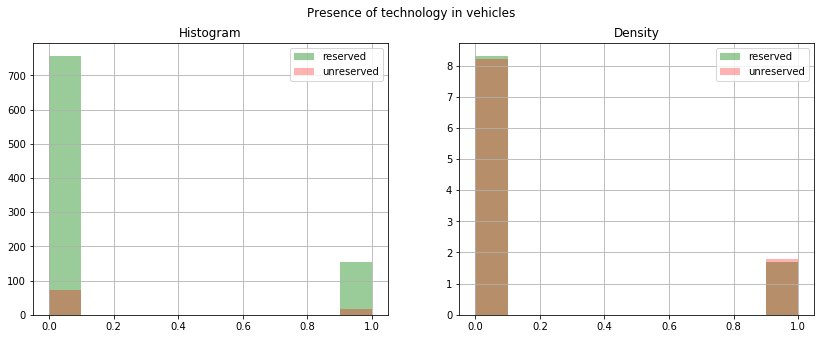

In [15]:
plot_hists_col('technology', 'Presence of technology in vehicles')

* From the _Histogram_ plot we can see that the number of reserved vehicles without technology _(technology=0)_ is significantly greater than the number of unreserved vehicles without technology _(technology=0)_. But this is makes sense, because 91.1% of the vehicles are reserved. The _Histogram_ plot does not provide with us much useful information to compare the influence of _technology_ on the chances of reserving a vehicle.
* When the number of samples in one class is significantly higher than the number of samples in another class, the _Density_ plot provides a better representation of the influence of a predictor variable on the target variable. From the _Density_ plot we observe that the proportion of reserved and unreserved vehicles without _technology_ are nearly the same. A similar pattern is observed for vehicles without _technology_. 

Let us investigate the other variables before we make conclusive remarks on the influence of _technology_ on vehicle reservations.

### How does _actual_price_ influence the chances of reserving a vehicle?

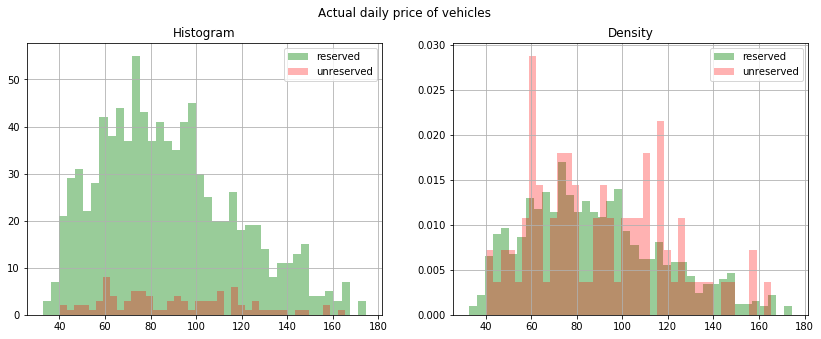

In [16]:
plot_hists_col('actual_price', 'Actual daily price of vehicles', bins=40)

A few observations from the _Denisty_ plot:

* If the actual daily price of a vehicle is less than \$60, a guest is more likely to reserve the vehicle.
* If the actual daily price of a vehicle is between $\$$60 and $\$$100, it makes it difficult to estimate (eye-ball) the effect of the price on reserving a vehicle.
* If the actual daily price of a vehicle is greater than $100, a vehicle is more likely to remain unreserved.

### How does _recommended_price_ influence the chances of reserving a vehicle?

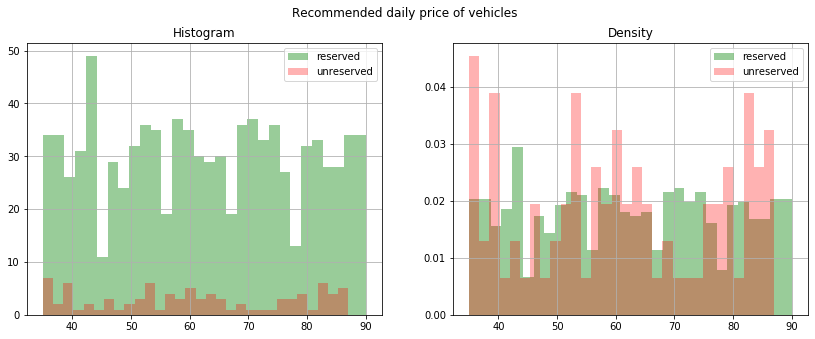

In [17]:
plot_hists_col('recommended_price', 'Recommended daily price of vehicles', bins=30)

* For recommended daily prices between $\$$40-$\$$50 and $\$$65-$\$$75, and greater than $\$$85, a guest is more likely to reserve the vehicles.
* For recommended daily prices between $\$$50-$\$$65 and $\$$75-$\$$85, a vehicle is more likely to remain unreserved.

A deeper dive is required to understand the combined effects of the actual daily price and recommended daily price on the chances of reserving a vehicle. We will get to this after we investigate the influence of each variable.

### How does _num_images_ (number of images) influence the chances of reserving a vehicle?

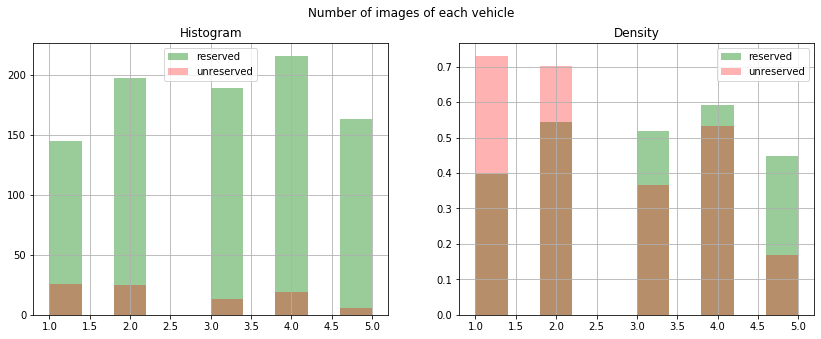

In [18]:
plot_hists_col('num_images', 'Number of images of each vehicle')

* We can observe from the _Density_ plot that, as the number of images of a vehicle increases, the likelihood of a guest reserving the vehicle also increases. 
* In the opposite case, if the number of images available of a vehicle are 1 or 2, the likelihood of the vehicle to remain unreserved increases. 

### How does _street_parked_ (vehicle requires street parking) influence the chances of reserving a vehicle?

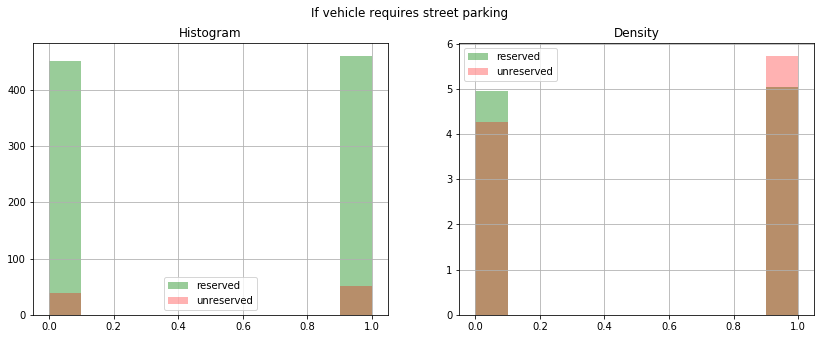

In [19]:
plot_hists_col('street_parked', 'If vehicle requires street parking ')

* If a vehicle doest require street parking, it positively affects the chances of reserving the vehicle. This makes intuitive sense; sometimes street parking can be a hassle. Especially, guests would want to safely park the vehicle to avoid extra fees due to illegal parking.
* From the _Density_ plot we can observe that the difference in proportions of reserved and unreserved vehicles that do require or do not require street parking are quite similar.

### How does _description_ influence the chances of reserving a vehicle?

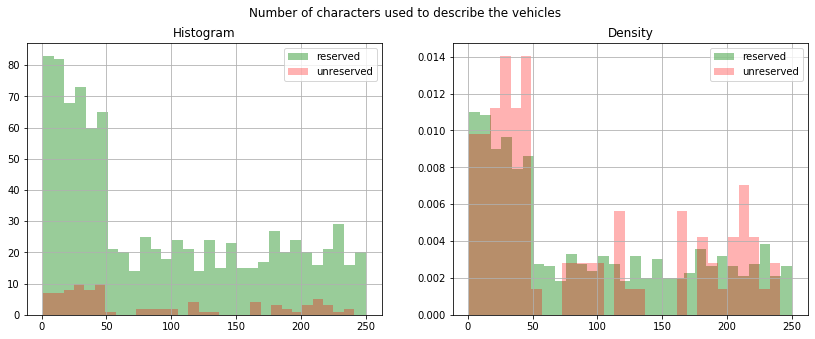

In [20]:
plot_hists_col('description', 'Number of characters used to describe the vehicles', bins=30)

* From the _Density_ plot we can observe that a lower count of the characters used to describe a vehicle, increases the likelihood of the vehicle to remain unreserved.
* We do see an interesting phenomenon in the range 200-225 characters. If the character count falls in this range the chances of a vehicle to remain unreserved increases. It will be interesting to see the presence of this phenomenon if we had more data.

### Next steps

So far, we have completed a preliminary investigation of the influence of the predictor variables on the likelihood of reserving a vehicle. But how do we know which factors are most important? We could do two things:

1. Create a classification model and via the model determine the most important factors. But that just helps us in identifying which factors influence the likelihood of a vehicle being reserved. 
2. Create a regression model to determine a ranked order of variable importances with respect to the reservation type. 

Before we go ahead and identify which process to choose from, it is vital to understand the guest's journey as they go about reserving a vehicle.

Step 1: A guest provides the location along with the time and date of the reservation.<br/>
Step 2: Guest selects vehicle of choice.<br/>
Step 3: Guest completes the payment and booking.<br/>

When the guest enters the date and time of the reservation we know if the reservation is either hourly, daily or weekly. If we are able to determine the most important factors for each reservation type we are able to maximize the number of reservations of each reservation type\*. Thereby, maximizing the total number of reservations of Company X's vehicles. **From this discussion, it is clear that we need to go with process `#2. Create a regression model to determine a ranked order of variable importances with respect to the reservation type.`**

*_The vehicles displayed by the search rank engine for each reservation type can be ranked based on the most important factors. This ensures we are maximizing the total number of reservations of vehicles, thereby maximizing the revenue generated by Company X._

## Investigate most important factors for reservation type 1: Hourly rental
<a id="hourly"></a>

In [21]:
# Filter data with respect to reservation type 1
vr_merged_1 = vr_merged[~vr_merged.reservation_type_1.isna()].reset_index(drop=True)
print(vr_merged_1.info())
vr_merged_1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   vehicle_id          761 non-null    int64  
 1   technology          761 non-null    int64  
 2   actual_price        761 non-null    float64
 3   recommended_price   761 non-null    int64  
 4   num_images          761 non-null    int64  
 5   street_parked       761 non-null    int64  
 6   description         761 non-null    int64  
 7   reserved_ind        761 non-null    int64  
 8   reservation_type_1  761 non-null    float64
 9   reservation_type_2  643 non-null    float64
 10  reservation_type_3  644 non-null    float64
dtypes: float64(4), int64(7)
memory usage: 65.5 KB
None


,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description,reserved_ind,reservation_type_1,reservation_type_2,reservation_type_3
0,1,1,67.85,59,5,0,7,1,1.0,NaN,NaN
1,2,0,100.70,53,5,0,224,1,4.0,3.0,NaN
2,3,0,74.00,74,4,1,21,1,1.0,9.0,7.0
3,4,0,135.00,75,1,0,184,1,1.0,NaN,1.0
4,6,0,82.15,53,5,1,44,1,4.0,4.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...
756,996,0,39.90,38,2,1,16,1,4.0,10.0,5.0
757,997,0,74.34,63,2,0,61,1,5.0,1.0,3.0
758,998,0,139.32,81,4,0,35,1,3.0,2.0,1.0
759,999,0,72.76,68,4,1,199,1,1.0,1.0,7.0


In [22]:
# Summary statistics of all data
vr_merged.describe()

,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description,reserved_ind,reservation_type_1,reservation_type_2,reservation_type_3
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,761.000000,760.000000,761.000000
mean,500.500000,0.170000,87.940730,62.206000,3.008000,0.511000,90.792000,0.911000,3.073587,2.706579,2.601840
std,288.819436,0.375821,29.724589,16.082544,1.348983,0.500129,76.948644,0.284886,2.115071,1.781018,1.702304
min,1.000000,0.000000,32.760000,35.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,250.750000,0.000000,64.942500,49.000000,2.000000,0.000000,25.000000,1.000000,1.000000,1.000000,1.000000
50%,500.500000,0.000000,83.930000,62.000000,3.000000,1.000000,57.500000,1.000000,3.000000,2.000000,2.000000
75%,750.250000,0.000000,107.010000,76.000000,4.000000,1.000000,158.000000,1.000000,4.000000,4.000000,3.000000
max,1000.000000,1.000000,174.440000,90.000000,5.000000,1.000000,250.000000,1.000000,14.000000,12.000000,12.000000


In [23]:
# Summary statistics of reservation type 1
vr_merged_1.describe()

,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description,reserved_ind,reservation_type_1,reservation_type_2,reservation_type_3
count,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.0,761.000000,643.000000,644.000000
mean,497.863338,0.185283,86.310880,62.091984,3.111695,0.507227,91.947438,1.0,3.073587,2.867807,2.788820
std,294.329541,0.388782,29.410716,15.977598,1.340417,0.500277,76.556549,0.0,2.115071,1.823934,1.753592
min,1.000000,0.000000,32.760000,35.000000,1.000000,0.000000,1.000000,1.0,1.000000,1.000000,1.000000
25%,237.000000,0.000000,63.840000,48.000000,2.000000,0.000000,26.000000,1.0,1.000000,1.000000,1.000000
50%,499.000000,0.000000,82.550000,62.000000,3.000000,1.000000,61.000000,1.0,3.000000,2.000000,2.000000
75%,750.000000,0.000000,103.950000,75.000000,4.000000,1.000000,157.000000,1.0,4.000000,4.000000,4.000000
max,1000.000000,1.000000,174.440000,90.000000,5.000000,1.000000,250.000000,1.0,14.000000,12.000000,12.000000


We are able to compare the summary statistics of the overall dataset against that of reservation type 1. We can observe that the statistics are nearly equal.

### Regression model

Since this is a first-pass in identifying the most important facators, let us set up a simple regression model that will work as our baseline. For iterative improvements, we can compare our performance against the baseline. The simplest regression model that we can develop is the **Linear Regression** model.

To investigate which factors are important, we need to build a regression model where the predictor variables are `technology, actual_price, recommended_price, num_images, street_parked, description` and the target variable is `reservation_type_1`.

Let's begin!

In [24]:
# Identify list of columns to use for regression
cols_nm = ['technology', 'actual_price', 'recommended_price', 'num_images', 
           'street_parked', 'description', 'reservation_type_1']
vr_merged_1 = vr_merged_1[cols_nm]
vr_merged_1

,technology,actual_price,recommended_price,num_images,street_parked,description,reservation_type_1
0,1,67.85,59,5,0,7,1.0
1,0,100.70,53,5,0,224,4.0
2,0,74.00,74,4,1,21,1.0
3,0,135.00,75,1,0,184,1.0
4,0,82.15,53,5,1,44,4.0
...,...,...,...,...,...,...,...
756,0,39.90,38,2,1,16,4.0
757,0,74.34,63,2,0,61,5.0
758,0,139.32,81,4,0,35,3.0
759,0,72.76,68,4,1,199,1.0


,technology,actual_price,recommended_price,num_images,street_parked,description,reservation_type_1
technology,1.000000,-0.476230,-0.416433,-0.042289,-0.003511,0.021061,0.346627
actual_price,-0.476230,1.000000,0.755025,-0.013315,-0.003531,-0.004468,-0.335523
recommended_price,-0.416433,0.755025,1.000000,-0.037773,0.011604,0.012832,-0.117125
num_images,-0.042289,-0.013315,-0.037773,1.000000,0.001738,-0.006662,0.135402
street_parked,-0.003511,-0.003531,0.011604,0.001738,1.000000,0.015435,0.011932
description,0.021061,-0.004468,0.012832,-0.006662,0.015435,1.000000,0.017755
reservation_type_1,0.346627,-0.335523,-0.117125,0.135402,0.011932,0.017755,1.000000


To output multiple subplots, the figure containing the passed axes is being cleared


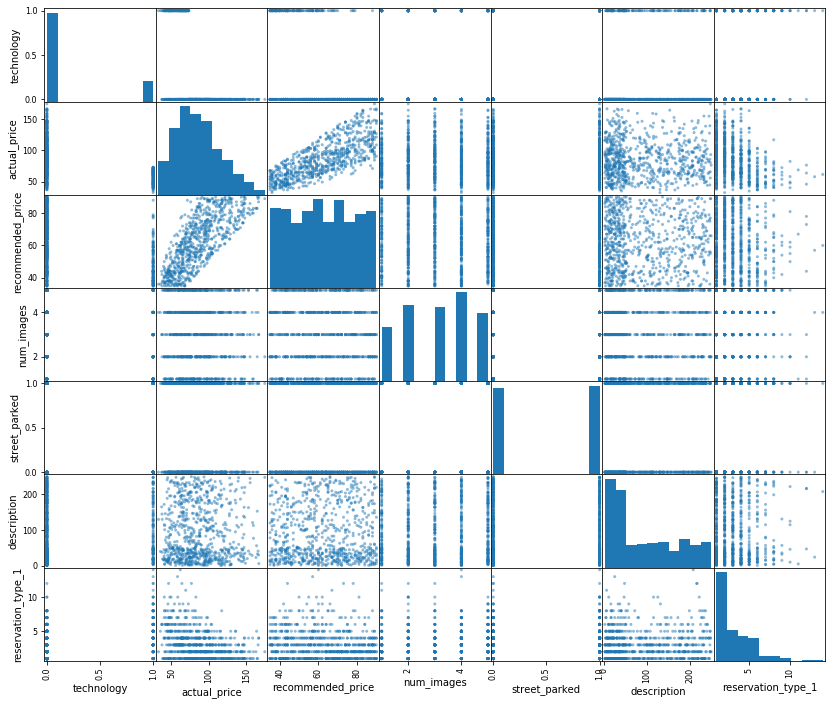

In [25]:
# Linear correlation among columns
display(pd.DataFrame(vr_merged_1.corr()))

fig, ax = plt.subplots()
fig.set_size_inches(14, 12)
scatter_matrix(vr_merged_1, ax=ax)
plt.show()

A few observations from the scatter matrix and correlations:

* _actual_price_ and _recommended_price_ share a high correlation. This makes sense. Company X provides a baseline price (recommended price) and the host is free to leverage the _recommended_price_ and set their own price, that is, _actual_price_.
* The _actual_price_ and _reservation_type_1_ share a negative correlation. As the _actual_price_ increases the number of reservations of type 1 decreases. We can see a similar behavior with _recommended_price_ and _reservation_type_1_ but with lesser relative strength.
* _technology_ and _num_images_ have a positive correlation with _reservation_type_1_ with _technology_ sharing a higher relative strength. 
* _street_parked_ and _description_ have a weak correlation with _reservation_type_1_.

So great, we know which factors are most important with respect to the reservation type 1. Unfortunately, not quite. There are a few disadvantages to using linear correlations to measure influence of each factor:

* Our data seems to be non-linear. Linear correlations are unable to pick the non-linear relationships between variables.
* Linear correlation does not work well between categorical and continuous variables. Point biserial correlation is a good metric to use to measure the strength of a relationship between categorical and continuous variables.
* Linear correlation only measures the strength of a relationship between two variables (preferrably continuous). Ideally, we want to determine the measure of strength between two or more variables.

In [26]:
# Define a list of column names to be used as features
feat_cols = ['technology', 'actual_price', 'recommended_price', 
             'num_images', 'street_parked', 'description']

# Creatre our X and y variables
X = vr_merged_1[feat_cols]
y = vr_merged_1['reservation_type_1']

In [27]:
# Create train and test datasets. 70/30 split between train and test datasets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

Given the values of the features are on different scales, it would be ideal to standardize the values before training a linear regression model. In order to set a baseline it is best to pass the feature matrix as it is. The next immediate iterative step could be to standardize the feature values. 

_Note: This has been done for hourly reservations. There is no difference in the model error. Hence, I continued without standardization. You can find the standardization in the Appendix._

In [28]:
# Build linear regression model
lr_1 = LinearRegression(n_jobs=-1)

# Fit the linear regression
lr_1.fit(X_train, y_train)

# Determine the train mean absolute error
train_pred = lr_1.predict(X_train)
print("Train MAE: ", mean_absolute_error(y_train, train_pred))

Train MAE:  1.412564689108501


In [29]:
# Determine the test mean absolute error
test_pred = lr_1.predict(X_test)
print("Test MAE: ", mean_absolute_error(y_test, test_pred))

Test MAE:  1.4124455483905114


The train and test mean absolute errors are nearly equal. Let's continue with our analysis.

In [30]:
# Print the coefficients of the linear model
lr_1_coef = lr_1.coef_
display(pd.DataFrame(lr_1_coef.reshape(1, -1), columns=X_train.columns))

,technology,actual_price,recommended_price,num_images,street_parked,description
0,1.161143,-0.03409,0.043847,0.189057,-0.143997,0.000157


We can't use the model coefficients to dictate the most important factors that drive the number of hourly reservations (reservation type 1) because our featues have different scales. Moreover, the coefficients do not represent the overall conditional dependence between the predictor variables. There are two aspects to conditional dependence: conditional presence of a variable and conditional absence of a variable. Linear regression is unable to learn the marginal effect of conditional absence of variables.

So, how exactly do we determine our most important factors, then? **Let me introduce you to SHAP!**

## What is SHAP???
<a id="shap"></a>

SHAP (SHapley Additive exPlanations) leverages coalitional game theory concepts to help explain the feature contributions of any machine learning model. 

Below are resources to learn more about SHAP:
1. [A Unified Approach to Interpreting Model Predictions](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf)
2. [SHAP - Github](https://github.com/slundberg/shap)
3. [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)
4. [Shapley values](https://christophm.github.io/interpretable-ml-book/shapley.html#shapley)

In [31]:
# Create the SHAP explainer instance
explainer = shap.LinearExplainer(lr_1, X, 
                                 feature_perturbation='correlation_dependent')  # the features
                                # are not independent. We want to determine the conditional
                                # power of our factors
shap_values = explainer.shap_values(X)

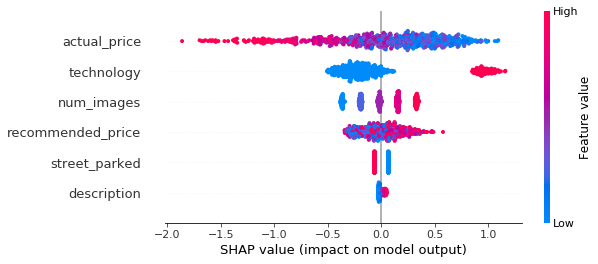

In [32]:
# SHAP summary plot
fig, ax = plt.subplots()
fig.set_size_inches(18, 8)
shap.summary_plot(shap_values, X)
plt.show()

### How do we read the above plot?

We have a ranked list of features on the right-hand side of the plot. The dots on the plot represents each data point in our dataset (for hourly reservations). The color represents the magnitude of the feature value. At the bottom of the plot is the range of SHAP values. It is the effect that each feature value of each data point has on the model's output.

Let's dive deeper and investigate the effects of each feature on hourly reservations.

### Effect of _actual_price_ on hourly reservations

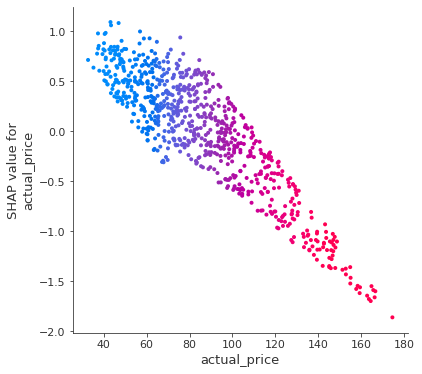

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
shap.dependence_plot('actual_price', shap_values, X, 
                     interaction_index='actual_price', ax=ax)
plt.show()

From the above plot we can see that the as the actual daily price increases the effect of the price on the number of reservations is inverse. With higher prices, the number of reservations decreases.

Let's look at a few examples.

In [34]:
# Pick a random data point with actual_price greater than $120
dp = vr_merged_1[vr_merged_1.actual_price > 120].sample(1, random_state=SEED)
dp_index = dp.index[0]

In [35]:
shap.force_plot(explainer.expected_value, shap_values[dp_index,:], X.iloc[dp_index,:])

The above graph is meant for a technical audience rather a non-technical audience. So what exactly is happening in the above graph.

Couple of important notes:
* Base value: it is the average prediction of the model.
* Model output value: Prediction made by the model.
* Red color: Positive impact on the prediction.
* Blue Color: Negative impact on the prediction.

With an _actual_price_ of $\$$119.50 the number of hourly reservations has been reduced from a potential average value of 3 reservations to 2.71 reservations. This is may not seem significant, but if there are thousands of such vehicles, there is a potential to loose hundreds of such hourly reservations.

### Effect of _technology_ on hourly reservations

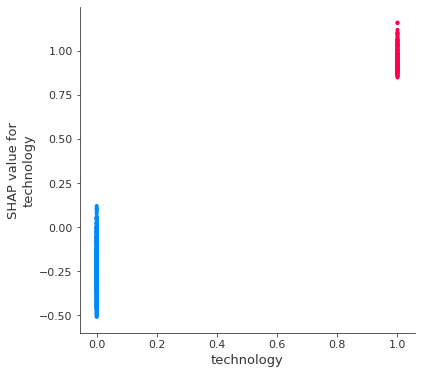

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
shap.dependence_plot('technology', shap_values, X, 
                     interaction_index='technology', ax=ax)
plt.show()

Though _technology_ is a categorical variable, SHAP has provided a range of effect values on the number of hourly reservations. Why is this so? Remember, when we had defined a class of the SHAP explainer, we had mentioned that we want SHAP to learn the conditional dependence between the other featues. Therefore, _technology_ has a range of impact values on the model's predictions.

Let's take a look at an example.

In [37]:
# Pick a random data point with technology present in the vehicle (technology=1)
dp = vr_merged_1[vr_merged_1.technology == 1].sample(1, random_state=SEED)
dp_index = dp.index[0]

In [38]:
shap.force_plot(explainer.expected_value, shap_values[dp_index,:], X.iloc[dp_index,:])

From the above graph we can see that _technology=1_ has the highest positive contribution to increase the number of hourly reservations from the average. Also, we can see that a lower _actual_price_ has contributede positively. Lastly, _recommended_price_ is not present in the above plot. It is because it had a negligible effect on the model output.

The given combination of feature values has helped pushed the hourly reservations from an average of 3 reservations to 4.18 reservations. That is great!!

### Effect of _num_images_ on hourly reservations

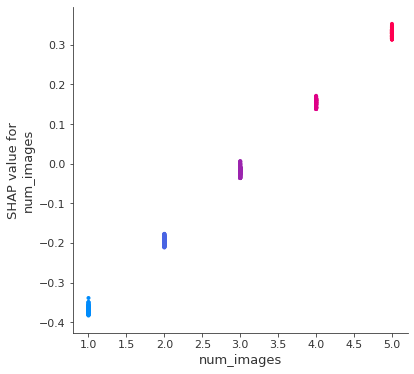

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
shap.dependence_plot('num_images', shap_values, X, 
                     interaction_index='num_images', ax=ax)
plt.show()

Each value of _num_images_ has a range of effects on the model predictions. The reasoning for this is the same as mentioned above, when investigating _technology_.

In our pre-liminray investigation I had estimated that higher the _num_images_, greater would its impact on increasing the number of reservations. This is exactly what we see in the above graph.

Let's learn more by taking a look at an example.

In [40]:
# Pick a random data point with num_images=5
dp = vr_merged_1[vr_merged_1.num_images == 5].sample(1, random_state=SEED)
dp_index = dp.index[0]

shap.force_plot(explainer.expected_value, shap_values[dp_index,:], X.iloc[dp_index,:])

From the above graph we can see that with a high number of images, along with the contribution of other features, the hourly reservations has increased from the average 3 reservations to 3.88 reservations.

### Effect of _recommended_price_ on hourly reservations

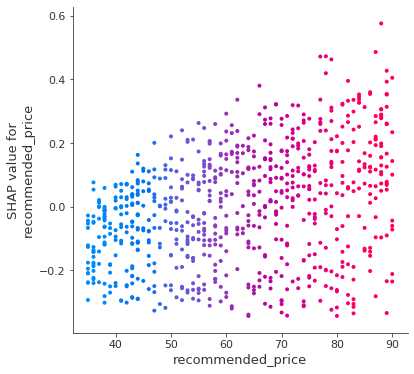

In [41]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
shap.dependence_plot('recommended_price', shap_values, X, 
                     interaction_index='recommended_price', ax=ax)
plt.show()

An increase in _recommended_price_ causes either a positive or a negative impact on the hourly reservations.

In [42]:
# Pick a random data point with recommended_price > $80
dp = vr_merged_1[vr_merged_1.recommended_price > 80].sample(1, random_state=SEED)
dp_index = dp.index[0]

shap.force_plot(explainer.expected_value, shap_values[dp_index,:], X.iloc[dp_index,:])

From the above graph we can see that a higher _recommended_price_ may lead to an increase in the hourly reservations from an average of 3 reservations to 3.80 reservations.

Let's take a look at another sample where a high _recommended_price_ leads to a decrease in hourly reservations.

In [43]:
# Pick a random data point with recommended_price > $85
cond = ((vr_merged_1.recommended_price > 85) & (
    shap_values[:,2] < 0))
dp = vr_merged_1[cond].sample(1, random_state=SEED)
dp_index = dp.index[0]

shap.force_plot(explainer.expected_value, shap_values[dp_index,:], X.iloc[dp_index,:])

From the above graph, we can see that even though the _recommended_price_ is high, it causes the hourly reservations to drop from an average of 3 reservations to 2.35 reservations.

But we can also see that the _actual_price_ is high as well. This coincides with our earlier finding. **It will be quite interesting to investigate the ratio of _actual_price to _recommended_price_.**

### Effect of _street_parked_ on hourly reservations

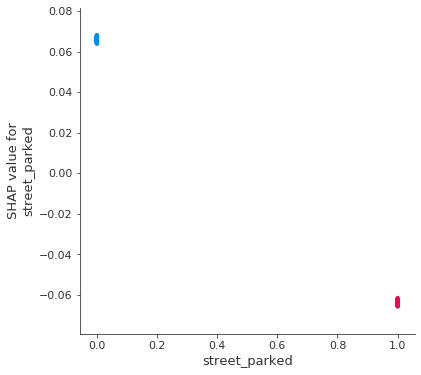

In [44]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
shap.dependence_plot('street_parked', shap_values, X, 
                     interaction_index='street_parked', ax=ax)
plt.show()

_street_parked_ though a categorical variable has a range (admittedly a small range for values 0 and 1) of effects on the number of hourly reservations.

Let's explore more with an example.

In [45]:
# Pick a random data point with street_parked == 1
dp = vr_merged_1[vr_merged_1.street_parked == 1].sample(1, random_state=SEED)
dp_index = dp.index[0]

shap.force_plot(explainer.expected_value, shap_values[dp_index,:], X.iloc[dp_index,:])

With _street_parked = 1_ the hourly reservation has reduced slightly (it has a small effect on the hourly reservations), from an average of 3 reservations to 2.89 reservations.

### Effect of _description_ on hourly reservations

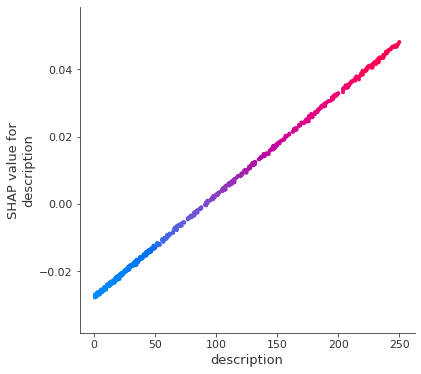

In [46]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
shap.dependence_plot('description', shap_values, X, 
                     interaction_index='description', ax=ax)
plt.show()

_description_ has the least effect on hourly reservations. As the number of characters in the description increases there is a small yet positive effect on the increase in the number of hourly reservations.

Let's take a look at an example.

In [47]:
# Pick a random data point with description > 200
dp = vr_merged_1[vr_merged_1.description > 200].sample(1, random_state=SEED)
dp_index = dp.index[0]

shap.force_plot(explainer.expected_value, shap_values[dp_index,:], X.iloc[dp_index,:])

As we have seen, from all of the abve plots, _description_ is missing. This is because the effect of it is almost negligible. If the number of characters used is greater than 200, then the average reservations increases by a minor 0.03-0.05 reservations.

So far, we have gone through the various factors and investigated the impact of these factors on the number of hourly reservations.

The ranked list of factors, from most important to least important:
1. actual_price
2. technology
3. num_images
4. recommended_price
5. street_parked
6. description

## Investigate most important factors for reservation type 2: Daily rental
<a id="daily"></a>

In [48]:
# Filter data with respect to reservation type 2
vr_merged_2 = vr_merged[~vr_merged.reservation_type_2.isna()].reset_index(drop=True)
print(vr_merged_2.info())
vr_merged_2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   vehicle_id          760 non-null    int64  
 1   technology          760 non-null    int64  
 2   actual_price        760 non-null    float64
 3   recommended_price   760 non-null    int64  
 4   num_images          760 non-null    int64  
 5   street_parked       760 non-null    int64  
 6   description         760 non-null    int64  
 7   reserved_ind        760 non-null    int64  
 8   reservation_type_1  643 non-null    float64
 9   reservation_type_2  760 non-null    float64
 10  reservation_type_3  639 non-null    float64
dtypes: float64(4), int64(7)
memory usage: 65.4 KB
None


,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description,reserved_ind,reservation_type_1,reservation_type_2,reservation_type_3
0,2,0,100.70,53,5,0,224,1,4.0,3.0,NaN
1,3,0,74.00,74,4,1,21,1,1.0,9.0,7.0
2,5,0,59.36,53,2,1,31,1,NaN,1.0,1.0
3,6,0,82.15,53,5,1,44,1,4.0,4.0,5.0
4,8,0,98.56,88,5,1,174,1,2.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
755,996,0,39.90,38,2,1,16,1,4.0,10.0,5.0
756,997,0,74.34,63,2,0,61,1,5.0,1.0,3.0
757,998,0,139.32,81,4,0,35,1,3.0,2.0,1.0
758,999,0,72.76,68,4,1,199,1,1.0,1.0,7.0


In [49]:
# Summary statistics of all data
vr_merged.describe()

,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description,reserved_ind,reservation_type_1,reservation_type_2,reservation_type_3
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,761.000000,760.000000,761.000000
mean,500.500000,0.170000,87.940730,62.206000,3.008000,0.511000,90.792000,0.911000,3.073587,2.706579,2.601840
std,288.819436,0.375821,29.724589,16.082544,1.348983,0.500129,76.948644,0.284886,2.115071,1.781018,1.702304
min,1.000000,0.000000,32.760000,35.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,250.750000,0.000000,64.942500,49.000000,2.000000,0.000000,25.000000,1.000000,1.000000,1.000000,1.000000
50%,500.500000,0.000000,83.930000,62.000000,3.000000,1.000000,57.500000,1.000000,3.000000,2.000000,2.000000
75%,750.250000,0.000000,107.010000,76.000000,4.000000,1.000000,158.000000,1.000000,4.000000,4.000000,3.000000
max,1000.000000,1.000000,174.440000,90.000000,5.000000,1.000000,250.000000,1.000000,14.000000,12.000000,12.000000


In [50]:
# Summary statistics of reservation type 2
vr_merged_2.describe()

,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description,reserved_ind,reservation_type_1,reservation_type_2,reservation_type_3
count,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.0,643.000000,760.000000,639.000000
mean,501.327632,0.164474,86.890158,62.438158,3.126316,0.505263,90.615789,1.0,3.269051,2.706579,2.751174
std,287.909418,0.370949,29.464328,15.948166,1.338531,0.500302,77.116699,0.0,2.179076,1.781018,1.748011
min,2.000000,0.000000,35.280000,35.000000,1.000000,0.000000,1.000000,1.0,1.000000,1.000000,1.000000
25%,259.750000,0.000000,63.990000,49.000000,2.000000,0.000000,24.000000,1.0,2.000000,1.000000,1.000000
50%,498.000000,0.000000,83.220000,63.000000,3.000000,1.000000,58.500000,1.0,3.000000,2.000000,2.000000
75%,750.250000,0.000000,103.680000,75.250000,4.000000,1.000000,158.000000,1.0,4.000000,4.000000,4.000000
max,1000.000000,1.000000,174.440000,90.000000,5.000000,1.000000,250.000000,1.0,14.000000,12.000000,12.000000


We are able to compare the summary statistics of the overall dataset against that of reservation type 2. We can observe that the statistics are nearly equal.

In [51]:
# Identify list of columns to use for regression
cols_nm = ['technology', 'actual_price', 'recommended_price', 'num_images', 
           'street_parked', 'description', 'reservation_type_2']
vr_merged_2 = vr_merged_2[cols_nm]
vr_merged_2

,technology,actual_price,recommended_price,num_images,street_parked,description,reservation_type_2
0,0,100.70,53,5,0,224,3.0
1,0,74.00,74,4,1,21,9.0
2,0,59.36,53,2,1,31,1.0
3,0,82.15,53,5,1,44,4.0
4,0,98.56,88,5,1,174,2.0
...,...,...,...,...,...,...,...
755,0,39.90,38,2,1,16,10.0
756,0,74.34,63,2,0,61,1.0
757,0,139.32,81,4,0,35,2.0
758,0,72.76,68,4,1,199,1.0


,technology,actual_price,recommended_price,num_images,street_parked,description,reservation_type_2
technology,1.000000,-0.452044,-0.396589,-0.018016,0.041475,-0.006907,0.027276
actual_price,-0.452044,1.000000,0.752028,-0.026276,0.007845,0.008683,-0.171758
recommended_price,-0.396589,0.752028,1.000000,-0.032962,0.013003,0.041105,0.040805
num_images,-0.018016,-0.026276,-0.032962,1.000000,-0.026571,0.020408,0.105099
street_parked,0.041475,0.007845,0.013003,-0.026571,1.000000,0.010331,-0.015269
description,-0.006907,0.008683,0.041105,0.020408,0.010331,1.000000,0.016915
reservation_type_2,0.027276,-0.171758,0.040805,0.105099,-0.015269,0.016915,1.000000


To output multiple subplots, the figure containing the passed axes is being cleared


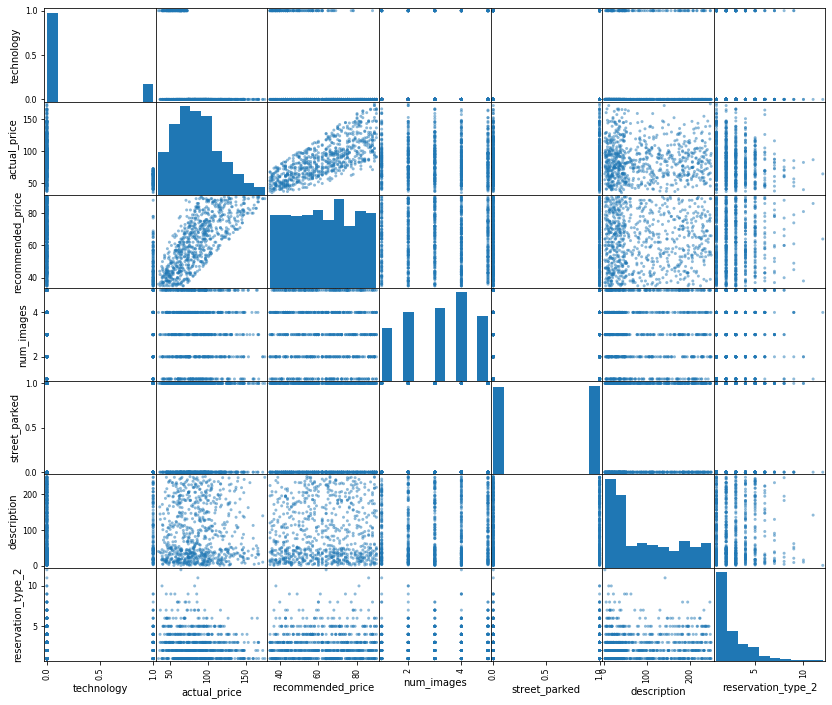

In [52]:
# Linear correlation among columns
display(pd.DataFrame(vr_merged_2.corr()))

fig, ax = plt.subplots()
fig.set_size_inches(14, 12)
scatter_matrix(vr_merged_2, ax=ax)
plt.show()

A few observations from the scatter matrix and correlations:

* The correlation values between the variables of reservation type 2 are similar to the correlation values between variables of reservation type 1. But one key difference is the relationship between _actual_price_ and _reservation_type_2. Though the relationship is negative, the strength of the relationship is relatively lower.

In [53]:
# Define a list of column names to be used as features
feat_cols = ['technology', 'actual_price', 'recommended_price', 
             'num_images', 'street_parked', 'description']

# Creatre our X and y variables
X = vr_merged_2[feat_cols]
y = vr_merged_2['reservation_type_2']

In [54]:
# Create train and test datasets. 70/30 split between train and test datasets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [55]:
# Build linear regression model
lr_2 = LinearRegression(n_jobs=-1)

# Fit the linear regression
lr_2.fit(X_train, y_train)

# Determine the train mean absolute error
train_pred = lr_2.predict(X_train)
print("Train MAE: ", mean_absolute_error(y_train, train_pred))

Train MAE:  1.2789208442807698


In [56]:
# Determine the test mean absolute error
test_pred = lr_2.predict(X_test)
print("Test MAE: ", mean_absolute_error(y_test, test_pred))

Test MAE:  1.3605273111418748


In [57]:
# Print the coefficients of the linear model
lr_2_coef = lr_2.coef_
display(pd.DataFrame(lr_2_coef.reshape(1, -1), columns=X_train.columns))

,technology,actual_price,recommended_price,num_images,street_parked,description
0,-0.238235,-0.030374,0.048694,0.172666,-0.048005,0.000168


Let's examine the SHAP values to determine the most important factors that drive the daily reservations.

In [58]:
# Create the SHAP explainer instance
explainer = shap.LinearExplainer(lr_2, X, 
                                 feature_perturbation='correlation_dependent')  # the features
                                # are not independent. We want to determine the conditional
                                # power of our factors
shap_values = explainer.shap_values(X)

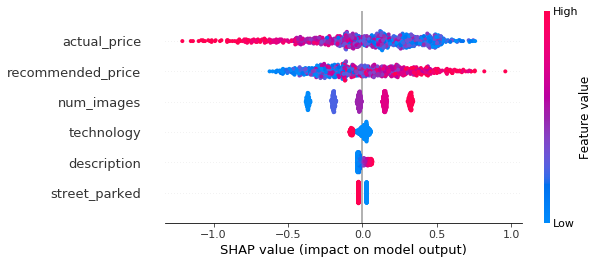

In [59]:
# SHAP summary plot
fig, ax = plt.subplots()
fig.set_size_inches(18, 8)
shap.summary_plot(shap_values, X)
plt.show()

The above summary plot of the SHAP values is similar to the summary plot we observed for the hourly reservations. But there are two key differences between the two plots - _technology_ and _recommended_price_ have swaped places, and when _technology = 1_ it leads to a decrease in the number of daily reservations.

* We observe the same pattern between SHAP values and _actual_price_. An increase in the _actual_price_ corresponds to a decrease in the daily reservations. The relationship between _recommended_price_ and SHAP values is vice versa.
* _technology_ , _street_parked_ and _description_ have a relatively narrow band of SHAP values. Their effect on the daily reservations is minimal.

Now we shall explore each factor along with examples.

### Effect of _actual_price_ on daily reservations

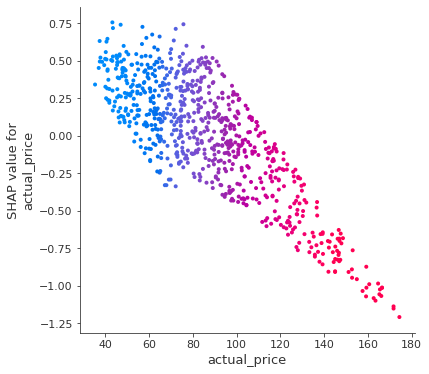

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
shap.dependence_plot('actual_price', shap_values, X, 
                     interaction_index='actual_price', ax=ax)
plt.show()

The above plot is very similar to the dependence plot we had seen with hourly reservations. As the actual daily price increases the effect of the price on the number of reservations is inverse. With higher prices, the number of reservations decreases.

Let's look at an example.

In [61]:
# Pick a random data point with actual_price greater than $120
dp = vr_merged_2[vr_merged_2.actual_price > 120].sample(1, random_state=SEED)
dp_index = dp.index[0]

shap.force_plot(explainer.expected_value, shap_values[dp_index,:], X.iloc[dp_index,:])

We can observe from the above graph that with an _actual_price_ greater than $\$$120 the daily reservations has reduced from the average of 2.72 reservations to 1.48 reservations. Though there are other factors responsible for this decrease, _actual_price_ has the largest effect. 

### Effect of _recommended_price_ on daily reservations

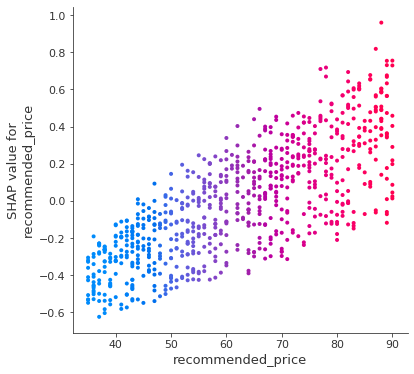

In [62]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
shap.dependence_plot('recommended_price', shap_values, X, 
                     interaction_index='recommended_price', ax=ax)
plt.show()

An increase in _recommended_price_ causes either a positive or a negative impact on the daily reservations. This pattern is similar to the one we saw in the hourly reservations.

In [63]:
# Pick a random data point with recommended_price > $80
dp = vr_merged_2[vr_merged_2.recommended_price > 80].sample(1, random_state=SEED)
dp_index = dp.index[0]

shap.force_plot(explainer.expected_value, shap_values[dp_index,:], X.iloc[dp_index,:])

From the above graph we can see that a higher _recommended_price_ has lead to an increase in the daily reservations from an average of 2.72 reservations to 2.88 reservations. Admittedly, this is not a significant increase in the daily reservations. This is because a high _actual_price_ has a much higer effect on the daily reservations. Whereas, a high _recommended_price_ has broad range of SHAP values, from -0.2 to 1.0. The effect of _recommended_price_ for this particular data point must be on the lower positive spectrum of SHAP values.

### Effect of _num_images_ on daily reservations

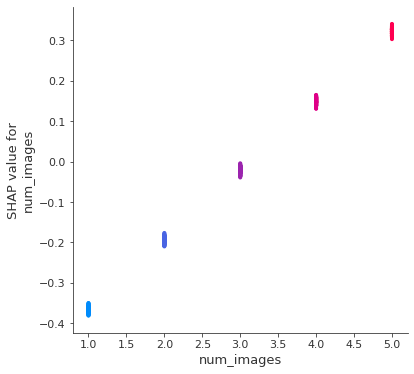

In [64]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
shap.dependence_plot('num_images', shap_values, X, 
                     interaction_index='num_images', ax=ax)
plt.show()

The SHAP values for various values of _num_images_ is nearly equal to the SHAP values we had seen with hourly reservations. Higher _num_images_, greater would its impact be on increasing the number of daily reservations.

Let's learn more by taking a look at an example.

In [65]:
# Pick a random data point with num_images=5
dp = vr_merged_2[vr_merged_2.num_images == 5].sample(1, random_state=SEED)
dp_index = dp.index[0]

shap.force_plot(explainer.expected_value, shap_values[dp_index,:], X.iloc[dp_index,:])

Though there is an increase from the average, 2.72 reservations, to 3.02 reservations. This increase is small, due to the large effect of high _actual_price_ on the number of daily reservations.

### Effect of _technology_ on daily reservations

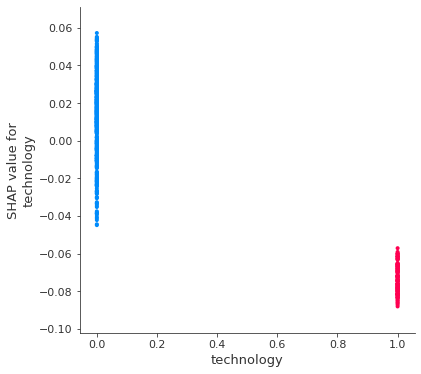

In [66]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
shap.dependence_plot('technology', shap_values, X, 
                     interaction_index='technology', ax=ax)
plt.show()

The pattern we observe in the above graph is opposite to the pattern we had witnessed with hourly reservations. If technology is present in the vehicle it adversely affects the number of daily reservations.

Let's take a look at an example.

In [67]:
# Pick a random data point with technology present in the vehicle (technology=1)
dp = vr_merged_2[vr_merged_2.technology == 1].sample(1, random_state=SEED)
dp_index = dp.index[0]

shap.force_plot(explainer.expected_value, shap_values[dp_index,:], X.iloc[dp_index,:])

Though there is an increase in the daily reservations from the average reservations, _technology = 1_ has contributed negatively to the number of daily reservations.

### Effect of _street_parked_ on daily reservations

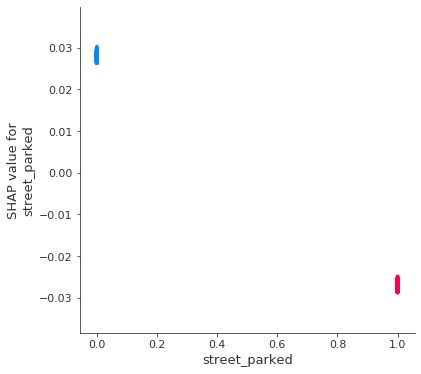

In [68]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
shap.dependence_plot('street_parked', shap_values, X, 
                     interaction_index='street_parked', ax=ax)
plt.show()

The dependence plot of _street_parked_ is nearly similar to the one we had observed with hourly reservations. _street_parked_ has a range (admittedly a small range for values 0 and 1) of effects on the number of daily reservations.

Let's explore more with an example.

In [69]:
# Pick a random data point with street_parked == 1
dp = vr_merged_2[vr_merged_2.street_parked == 1].sample(1, random_state=SEED)
dp_index = dp.index[0]

shap.force_plot(explainer.expected_value, shap_values[dp_index,:], X.iloc[dp_index,:])

In the above plot, there are a three factors missing ( _street_parked_ being one of them), this is because of the marginal effects of these factors on the number of daily reservations.

### Effect of _description_ on daily reservations

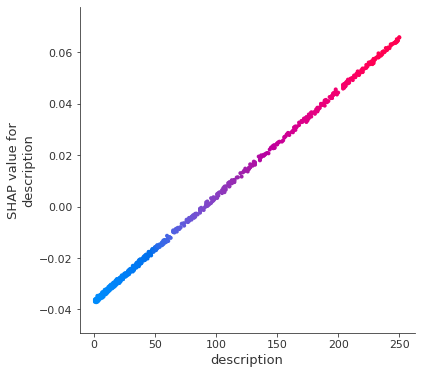

In [70]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
shap.dependence_plot('description', shap_values, X, 
                     interaction_index='description', ax=ax)
plt.show()

_description_ has the same linear plot for both hourly and daily reservations. As the number of characters in the _description_ increases there is a small yet positive effect on the increase in the number of daily reservations.

Let's take a look at an example.

In [71]:
# Pick a random data point with description > 200
dp = vr_merged_2[vr_merged_2.description > 200].sample(1, random_state=SEED)
dp_index = dp.index[0]

shap.force_plot(explainer.expected_value, shap_values[dp_index,:], X.iloc[dp_index,:])

As expected, a large number of characters used in the vehicle description leads to a marginal increase in the daily reservations.

So far, we have gone through the various factors and investigated the impact of these factors on the number of daily reservations.

The ranked list of factors, from most important to least important:
1. actual_price
2. recommended_price
3. num_images
4. technology
5. street_parked
6. description

## Investigate most important factors for reservation type 3: Weekly rental
<a id="weekly"></a>

In [72]:
# Filter data with respect to reservation type 2
vr_merged_3 = vr_merged[~vr_merged.reservation_type_3.isna()].reset_index(drop=True)
print(vr_merged_3.info())
vr_merged_3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   vehicle_id          761 non-null    int64  
 1   technology          761 non-null    int64  
 2   actual_price        761 non-null    float64
 3   recommended_price   761 non-null    int64  
 4   num_images          761 non-null    int64  
 5   street_parked       761 non-null    int64  
 6   description         761 non-null    int64  
 7   reserved_ind        761 non-null    int64  
 8   reservation_type_1  644 non-null    float64
 9   reservation_type_2  639 non-null    float64
 10  reservation_type_3  761 non-null    float64
dtypes: float64(4), int64(7)
memory usage: 65.5 KB
None


,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description,reserved_ind,reservation_type_1,reservation_type_2,reservation_type_3
0,3,0,74.00,74,4,1,21,1,1.0,9.0,7.0
1,4,0,135.00,75,1,0,184,1,1.0,NaN,1.0
2,5,0,59.36,53,2,1,31,1,NaN,1.0,1.0
3,6,0,82.15,53,5,1,44,1,4.0,4.0,5.0
4,8,0,98.56,88,5,1,174,1,2.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
756,996,0,39.90,38,2,1,16,1,4.0,10.0,5.0
757,997,0,74.34,63,2,0,61,1,5.0,1.0,3.0
758,998,0,139.32,81,4,0,35,1,3.0,2.0,1.0
759,999,0,72.76,68,4,1,199,1,1.0,1.0,7.0


In [73]:
# Summary statistics of all data
vr_merged.describe()

,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description,reserved_ind,reservation_type_1,reservation_type_2,reservation_type_3
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,761.000000,760.000000,761.000000
mean,500.500000,0.170000,87.940730,62.206000,3.008000,0.511000,90.792000,0.911000,3.073587,2.706579,2.601840
std,288.819436,0.375821,29.724589,16.082544,1.348983,0.500129,76.948644,0.284886,2.115071,1.781018,1.702304
min,1.000000,0.000000,32.760000,35.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,250.750000,0.000000,64.942500,49.000000,2.000000,0.000000,25.000000,1.000000,1.000000,1.000000,1.000000
50%,500.500000,0.000000,83.930000,62.000000,3.000000,1.000000,57.500000,1.000000,3.000000,2.000000,2.000000
75%,750.250000,0.000000,107.010000,76.000000,4.000000,1.000000,158.000000,1.000000,4.000000,4.000000,3.000000
max,1000.000000,1.000000,174.440000,90.000000,5.000000,1.000000,250.000000,1.000000,14.000000,12.000000,12.000000


In [74]:
# Summary statistics of reservation type 3
vr_merged_3.describe()

,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description,reserved_ind,reservation_type_1,reservation_type_2,reservation_type_3
count,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.0,644.000000,639.000000,761.000000
mean,487.059133,0.162943,86.741025,62.524310,3.135348,0.508541,90.490145,1.0,3.277950,2.874804,2.601840
std,288.688186,0.369557,29.156499,15.891234,1.328364,0.500256,77.368124,0.0,2.169794,1.852722,1.702304
min,3.000000,0.000000,35.280000,35.000000,1.000000,0.000000,1.000000,1.0,1.000000,1.000000,1.000000
25%,233.000000,0.000000,64.660000,49.000000,2.000000,0.000000,24.000000,1.0,2.000000,1.000000,1.000000
50%,480.000000,0.000000,83.220000,62.000000,3.000000,1.000000,58.000000,1.0,3.000000,2.000000,2.000000
75%,730.000000,0.000000,103.680000,75.000000,4.000000,1.000000,157.000000,1.0,4.000000,4.000000,3.000000
max,1000.000000,1.000000,174.440000,90.000000,5.000000,1.000000,250.000000,1.0,14.000000,12.000000,12.000000


We are able to compare the summary statistics of the overall dataset against that of reservation type 3. We can observe that the statistics are nearly equal.

In [75]:
# Identify list of columns to use for regression
cols_nm = ['technology', 'actual_price', 'recommended_price', 'num_images', 
           'street_parked', 'description', 'reservation_type_3']
vr_merged_3 = vr_merged_3[cols_nm]
vr_merged_3

,technology,actual_price,recommended_price,num_images,street_parked,description,reservation_type_3
0,0,74.00,74,4,1,21,7.0
1,0,135.00,75,1,0,184,1.0
2,0,59.36,53,2,1,31,1.0
3,0,82.15,53,5,1,44,5.0
4,0,98.56,88,5,1,174,4.0
...,...,...,...,...,...,...,...
756,0,39.90,38,2,1,16,5.0
757,0,74.34,63,2,0,61,3.0
758,0,139.32,81,4,0,35,1.0
759,0,72.76,68,4,1,199,7.0


,technology,actual_price,recommended_price,num_images,street_parked,description,reservation_type_3
technology,1.000000,-0.454109,-0.386492,-0.023542,0.020931,0.006729,0.017510
actual_price,-0.454109,1.000000,0.752674,-0.042315,-0.024836,-0.019741,-0.167616
recommended_price,-0.386492,0.752674,1.000000,-0.055164,-0.017033,0.012887,0.014148
num_images,-0.023542,-0.042315,-0.055164,1.000000,0.005188,0.036648,0.128019
street_parked,0.020931,-0.024836,-0.017033,0.005188,1.000000,-0.000329,-0.021495
description,0.006729,-0.019741,0.012887,0.036648,-0.000329,1.000000,0.004011
reservation_type_3,0.017510,-0.167616,0.014148,0.128019,-0.021495,0.004011,1.000000


To output multiple subplots, the figure containing the passed axes is being cleared


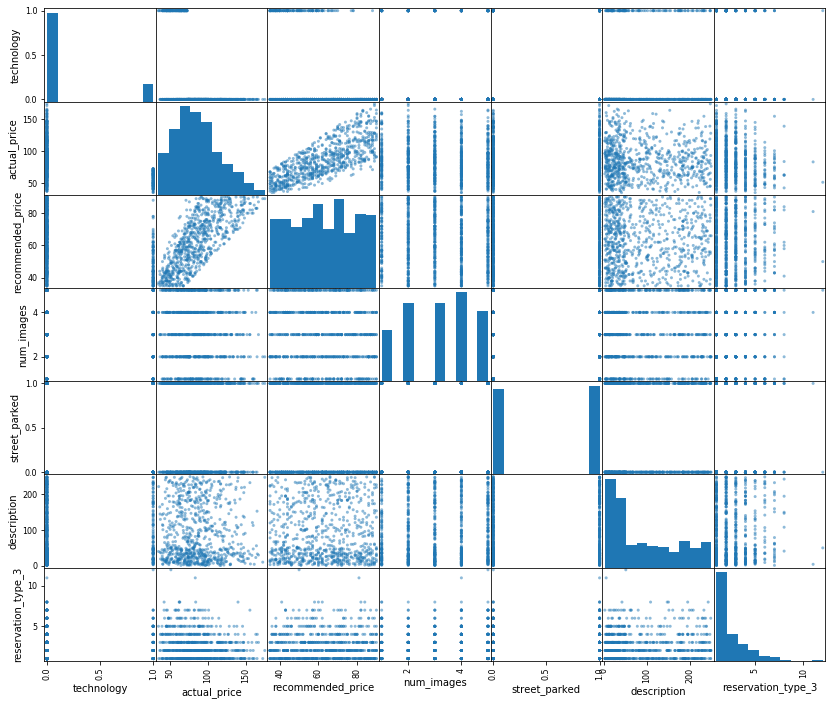

In [76]:
# Linear correlation among columns
display(pd.DataFrame(vr_merged_3.corr()))

fig, ax = plt.subplots()
fig.set_size_inches(14, 12)
scatter_matrix(vr_merged_3, ax=ax)
plt.show()

A few observations from the scatter matrix and correlation values:

* The correlation values between the variables of reservation type 3 are similar to the correlation values between variables of reservation type 1, and nearly the same as the correlation values between the variables of reservation type 2. 
* The relationship between _actual_price_ and _reservation_type_3_. Though the relationship is negative, the strength of the relationship is relatively lower in comparison to the correlation between _actual_price_ and the number of hourly reservations.

In [77]:
# Define a list of column names to be used as features
feat_cols = ['technology', 'actual_price', 'recommended_price', 
             'num_images', 'street_parked', 'description']

# Creatre our X and y variables
X = vr_merged_3[feat_cols]
y = vr_merged_3['reservation_type_3']

In [78]:
# Create train and test datasets. 70/30 split between train and test datasets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [79]:
# Build linear regression model
lr_3 = LinearRegression(n_jobs=-1)

# Fit the linear regression
lr_3.fit(X_train, y_train)

# Determine the train mean absolute error
train_pred = lr_3.predict(X_train)
print("Train MAE: ", mean_absolute_error(y_train, train_pred))

Train MAE:  1.2549047873384298


In [80]:
# Determine the test mean absolute error
test_pred = lr_3.predict(X_test)
print("Test MAE: ", mean_absolute_error(y_test, test_pred))

Test MAE:  1.2667461315006467


In [81]:
# Print the coefficients of the linear model
lr_3_coef = lr_3.coef_
display(pd.DataFrame(lr_3_coef.reshape(1, -1), columns=X_train.columns))

,technology,actual_price,recommended_price,num_images,street_parked,description
0,-0.077048,-0.026781,0.036418,0.207738,-0.187044,-0.000554


Let's examine the SHAP values to determine the most important factors that drive the weekly reservations.

In [82]:
# Create the SHAP explainer instance
explainer = shap.LinearExplainer(lr_3, X, 
                                 feature_perturbation='correlation_dependent')  # the features
                                # are not independent. We want to determine the conditional
                                # power of our factors
shap_values = explainer.shap_values(X)

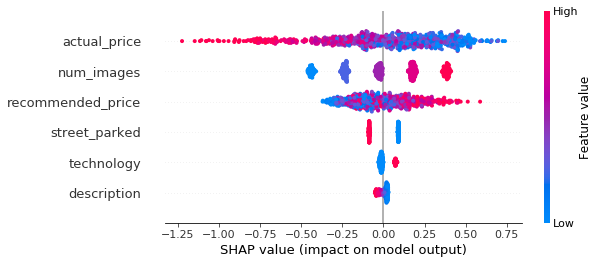

In [83]:
# SHAP summary plot
fig, ax = plt.subplots()
fig.set_size_inches(18, 8)
shap.summary_plot(shap_values, X)
plt.show()

There are some similarities between the above summary plot and the other two summary plots belonging to hourly and daily reservations.

* The pattern of _actual_price_ is similar to that observed with hourly and daily reservations.
* _technology_ has the least impact on weekly reservations.
* So far we have observed that an increase in the number of character used to describe the vehicle helps in increasing the number of hourly and daily reservations. But with weekly reservations we observe an inverse pattern. An increase in the number of characters leads to a decreease in the weekly reservations. This is an interesting phenomenon that we have come across. It begs the question - as we gather more data do we continue observing the same phenomenon?
* _num_images_ for the first time has the second highest impact on the weekly reservations.
* The pattern of SHAP values of _recommended_price_ resembles that of hourly reservations.
* _technology_ , _street_parked_ and _description_ have a relatively narrow band of SHAP values. Their effect on the weekly reservations is minimal.

Now we shall explore each factor along with examples.

### Effect of _actual_price_ on weekly reservations

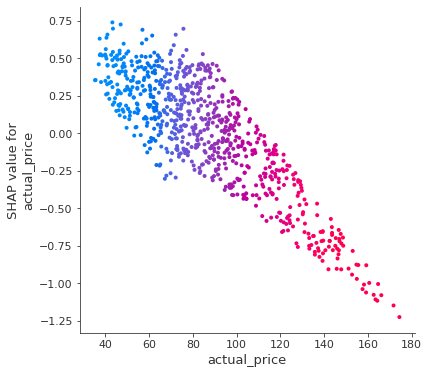

In [84]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
shap.dependence_plot('actual_price', shap_values, X, 
                     interaction_index='actual_price', ax=ax)
plt.show()

The above plot is very similar to the dependence plot we had seen with hourly and daily reservations. As the actual daily price increases the effect of the price on the number of weekly reservations is inverse. With higher prices, the number of reservations decreases.

Let's look at an example.

In [85]:
# Pick a random data point with actual_price greater than $120
dp = vr_merged_3[vr_merged_3.actual_price > 120].sample(1, random_state=SEED)
dp_index = dp.index[0]

shap.force_plot(explainer.expected_value, shap_values[dp_index,:], X.iloc[dp_index,:])

We can observe from the above graph that with an _actual_price_ greater than $\$$120 the daily reservations has reduced from the average of 2.57 reservations to 1.74 reservations. Though there are other factors responsible for this decrease, _actual_price_ has the largest effect. 

### Effect of _num_images_ on weekly reservations

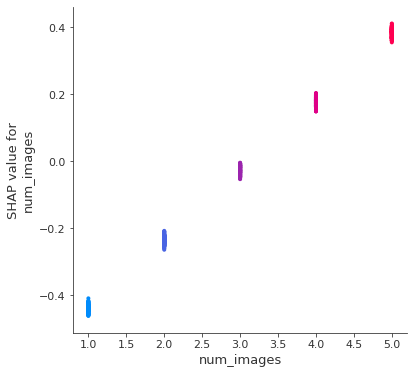

In [86]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
shap.dependence_plot('num_images', shap_values, X, 
                     interaction_index='num_images', ax=ax)
plt.show()

The SHAP values of _num_images_ is slightly larger than the SHAP values we had seen with hourly and daily reservations. Higher _num_images_, greater would its impact be on increasing the number of weekly reservations.

Let's learn more by taking a look at an example.

In [87]:
# Pick a random data point with num_images=5
dp = vr_merged_3[vr_merged_3.num_images == 5].sample(1, random_state=SEED)
dp_index = dp.index[0]

shap.force_plot(explainer.expected_value, shap_values[dp_index,:], X.iloc[dp_index,:])

There is an increase from the average, 2.57 reservations, to 3.01 reservations. _num_images_ has the largest impact on increasing the weekly reservations from the average predicted weekly reservations.

### Effect of _recommended_price_ on weekly reservations

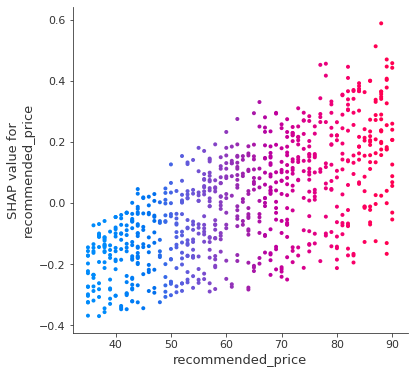

In [88]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
shap.dependence_plot('recommended_price', shap_values, X, 
                     interaction_index='recommended_price', ax=ax)
plt.show()

An increase in _recommended_price_ causes either a positive or a negative impact on the daily reservations. This pattern is similar to the ones we saw in the hourly and daily reservations.

In [89]:
# Pick a random data point with recommended_price > $80
dp = vr_merged_3[vr_merged_3.recommended_price > 80].sample(1, random_state=SEED)
dp_index = dp.index[0]

shap.force_plot(explainer.expected_value, shap_values[dp_index,:], X.iloc[dp_index,:])

From the above graph we can see that a higher _recommended_price_ has lead to an increase in the daily reservations from an average, 2.57 reservations to 2.80 reservations. Admittedly, this is not a significant increase in the weekly reservations. This is because the number of vehicle images is just 2, thereby having a strong effect in decreasing the weekly reservations.

### Effect of _street_parked_ on weekly reservations

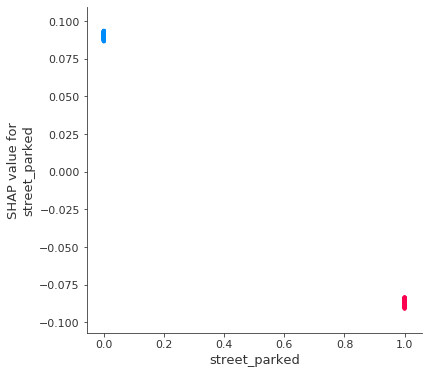

In [90]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
shap.dependence_plot('street_parked', shap_values, X, 
                     interaction_index='street_parked', ax=ax)
plt.show()

The dependence plot of _street_parked_ has a much broader range of SHAP values than what we had observed with the hourly and daily reservations. _street_parked_ has a range (admittedly a small range for values 0 and 1) of effects,  on the number of daily reservations.

Let's explore more with an example.

In [91]:
# Pick a random data point with street_parked == 1
dp = vr_merged_3[vr_merged_3.street_parked == 1].sample(1, random_state=SEED)
dp_index = dp.index[0]

shap.force_plot(explainer.expected_value, shap_values[dp_index,:], X.iloc[dp_index,:])

As we can see, if the vehicle has been street parked, it leads to a lower weekly reservation value.

### Effect of _description_ on weekly reservations

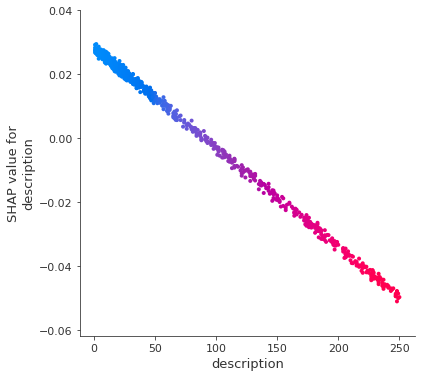

In [92]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
shap.dependence_plot('description', shap_values, X, 
                     interaction_index='description', ax=ax)
plt.show()

As discussed earlier, as the host uses more characters to describe the vehicle, it reduces (admittedly a marginal amount) the number of weekly reservations.

Let's take a look at an example.

In [93]:
# Pick a random data point with description > 200
dp = vr_merged_3[vr_merged_3.description > 200].sample(1, random_state=SEED)
dp_index = dp.index[0]

shap.force_plot(explainer.expected_value, shap_values[dp_index,:], X.iloc[dp_index,:])

As expected, a large number of characters used in the vehicle description leads to a marginal decrease in the weekly reservations.

### Effect of _technology_ on weekly reservations

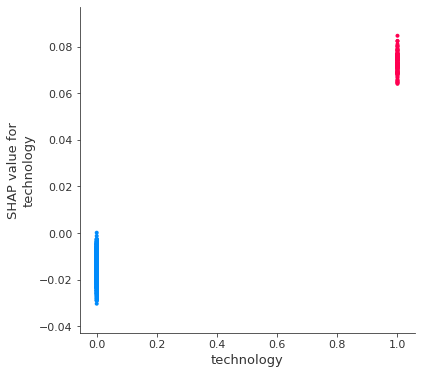

In [94]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
shap.dependence_plot('technology', shap_values, X, 
                     interaction_index='technology', ax=ax)
plt.show()

The pattern we observe in the above graph is similar to the pattern we had witnessed with hourly reservations. If technology is present in the vehicle it increases (admittedly by a small amount) the number of weekly reservations.

Let's take a look at an example.

In [95]:
# Pick a random data point with technology present in the vehicle (technology=1)
dp = vr_merged_3[vr_merged_3.technology == 1].sample(1, random_state=SEED)
dp_index = dp.index[0]

shap.force_plot(explainer.expected_value, shap_values[dp_index,:], X.iloc[dp_index,:])

Though there has been a decrease in the number of weekly reservations from the average, 2.57 reservations, to 1.94 reservations, the presence of technology in the vehicle has increased the weekly reservations by a marginal amount.

So far, we have gone through the various factors and investigated the impact of these factors on the number of weekly reservations.

The ranked list of factors, from most important to least important are:
1. actual_price
2. num_images
3. recommended_price
4. street_parked
5. description
6. technology

## Conclusions, Part I: Which factors seem to be most important in driving total # of reservations for our vehicles?
<a id="part1"></a>

Great! We have completed our journey of investigating the important factors that drive the total number of reservations of Company X's vehicles. Our approach to the problem at hand has been by determining the important factors for each reservation type: `hourly, daily and weekly reservations`. By identifying the factors that will help maximize the number of reservations for each reservation type, we will end up maximizing the total number of reservations for the vehicles.

### Hourly reservations
The ranked (from most important to least important) list of factors are as follows: 
1. **actual_price:** inversely proportional to number of hourly reservations
2. **technology:** presence of technology in the vehicle is proportional to number of hourly reservations
3. **num_images:** presence of 4 or 5 images is proportional to number of hourly reservations. 5 images has the highest impact.
4. **recommended_price:** proportional to number of hourly reservations. It would be interesting to explore the effect of the ratio of actual daily price to recommended daily price on the number of hourly reservations.
5. **street_parked:** if the vehicle does not have to be street parked it increases (marginal contributions) the number of hourly reservations.
6. **description:** if a host uses more characters to describe the vehicle it increases (marginal contributions) the number of hourly reservations.

### Daily reservations
The ranked (from most important to least important) list of factors are as follows: 
1. **actual_price:** inversely proportional to number of daily reservations
2. **recommended_price:** proportional to number of daily reservations. It would be interesting to explore the effect of the ratio of actual daily price to recommended daily price on the number of daily reservations.
3. **num_images:** presence of 4 or 5 images is proportional to number of daily reservations. 5 images has the highest impact.
4. **technology:** presence of technology in the vehicle is inversely proportional to number of daily reservations. This phenomenon requires a deeper dive. Why does technology have an adverse imapct?
5. **street_parked:** if the vehicle does not have to be street parked it increases (marginal contributions) the number of daily reservations.
6. **description:** if a host uses more characters to describe the vehicle it increases (marginal contributions) the number of daily reservations.

### Weekly reservations
The ranked (from most important to least important) list of factors are as follows: 
1. **actual_price:** inversely proportional to number of weekly reservations. The effect of actual daily price on weekly reservations is lower than the effect of the same on hourly and daily reservations.
2. **num_images:** presence of 4 or 5 images is proportional to number of weekly reservations. 5 images has the highest impact.
3. **recommended_price:** proportional to number of weekly reservations. It would be interesting to explore the effect of the ratio of actual daily price to recommended daily price on the number of weekly reservations.
4. **street_parked:** if the vehicle does not have to be street parked it increases (marginal contributions) the number of weekly reservations.
5. **description:** if a host uses more characters to describe the vehicle it decreases (marginal contributions) the number of weekly reservations. This is another interesting phenomenon to explore.
4. **technology:** presence of technology in the vehicle is proportional to number of weekly reservations. This phenomenon requires a deeper dive too. My assumption is that weekly rentals are primarily used by guests who travel. If majority of these guests land at the airport they would prefer using a vehicle that has Company X Go. This allows the guest to instantly book the vehicle and pick it up without having to meet with the host.

## Conclusions, Part II: How does the car's technology type seem to affect reservations?
<a id="part2"></a>

### Hourly reservations
* Presence of technology in the vehicle is proportional to number of hourly reservations. The effect of technology on the number of hourly vehicles is stronger than the effect of technology on daily and weekly reservations. 
* More than the presence of technology in the vehicle, I think there is another factor, most likely location, that leads to the inversely proportional relationship between technology and hourly reservations. Maybe the location of vehicles with Company X Go is primarily at airports. Company X Go is currently available in LA, SF, San Diego and London. In these locations, the airports are some distance away from majority of the residential localities. Guests who require hourly rentals would prefer to have quick access to a vehicle, preferably closer to their homes or offices.

### Daily reservations
* Presence of technology in the vehicle is inversely proportional to number of daily reservations. The effect of technology on the number of daily reservations is lesser than the effect of technology on hourly reservations but, greater than the effect of technology on weekly reservations.
* Similar to hourly reservations, I think there is another factor, most likely location, that leads to the inversely proportional relationship between technology and daily reservations. Maybe the location of vehicles with Company X Go is primarily at airports. Company X Go is currently available in LA, SF, San Diego and London. In these locations, the airports are some distance away from majority of the residential localities. Guests who require hourly rentals would prefer to have quick access to a vehicle, preferably closer to their homes or offices.

### Weekly reservations
* Presence of technology in the vehicle is proportional to number of weekly reservations. The effect of technology on the number of weekly reservations is the least relative to the effect of technology on hourly and daily reservations.
* My assumption for why technology is proporational to weekly reservations, unlike in hourly and daily reservations, is as follows - weekly rentals are primarily used by guests who travel. If majority of these guests land at airports they would prefer using a vehicle that has Company X Go. This allows the guest to instantly book the vehicle and pick it up without having to meet with the host.
* My next assumption on why technology has the weakest effect on weekly reservations is, when a guest is looking to reserve a vehicle for a week, price and images are going to be the most important factors. As we have seen in the SHAP summary plot for weekly reservations, the remaining factors, technology, street parking and description have weak effects on the number of weekly reservations. These three factors have similar ranges of SHAP values.

## Next Steps
<a id="next"></a>

If I had more time to work on the assignment, my next steps would be:
1. Investigate the SHAP dependence plots between the factors for hourly, daily and weekly reservations. 
2. Engineer a few features, like - ratio of actual price to recommended price and ratio of description to images and study their effects on the total number of reservations.
3. Identify range of values for each factor that can help maximize the hourly, daily and weekly reservations.
4. Request new factors, such as - vehicle pickup location, type of vehicle, number of seats, number of passengers associated to reservation, pickup time, and drop-off time.

## Appendix
<a id="appendix"></a>

### Standardizing data for hourly reservations

In [96]:
# Import method to perform standardization
from sklearn.preprocessing import StandardScaler

In [97]:
# Create a copy of the dataframe used to analyze hourly reservations
std_vr_merged_1 = vr_merged_1.copy()
std_vr_merged_1

,technology,actual_price,recommended_price,num_images,street_parked,description,reservation_type_1
0,1,67.85,59,5,0,7,1.0
1,0,100.70,53,5,0,224,4.0
2,0,74.00,74,4,1,21,1.0
3,0,135.00,75,1,0,184,1.0
4,0,82.15,53,5,1,44,4.0
...,...,...,...,...,...,...,...
756,0,39.90,38,2,1,16,4.0
757,0,74.34,63,2,0,61,5.0
758,0,139.32,81,4,0,35,3.0
759,0,72.76,68,4,1,199,1.0


In [98]:
# Define the standard scaler
sc = StandardScaler()

# Standardize actual_price
std_actual_price = sc.fit_transform(std_vr_merged_1.actual_price.values.reshape(-1, 1))
# Standardize recommended_price
std_rec_price = sc.fit_transform(std_vr_merged_1.recommended_price.values.reshape(-1, 1))
# Standardize description
std_desc = sc.fit_transform(std_vr_merged_1.description.values.reshape(-1, 1))

std_vr_merged_1['std_actual_price'] = std_actual_price
std_vr_merged_1['std_desc'] = std_desc
std_vr_merged_1['std_rec_price'] = std_rec_price

# List of columns to use as features
feat_cols = ['technology', 'std_actual_price', 'std_rec_price', 'num_images', 'street_parked',
            'std_desc']

# Create the X and y variables to store the predictor and target variables respectively
X = std_vr_merged_1[feat_cols]
y = std_vr_merged_1['reservation_type_1']

# Summary statistics of the standardized data
X.describe()

,technology,std_actual_price,std_rec_price,num_images,street_parked,std_desc
count,761.000000,7.610000e+02,7.610000e+02,761.000000,761.000000,7.610000e+02
mean,0.185283,-5.755361e-17,1.067915e-16,3.111695,0.507227,1.145513e-16
std,0.388782,1.000658e+00,1.000658e+00,1.340417,0.500277,1.000658e+00
min,0.000000,-1.821992e+00,-1.696738e+00,1.000000,0.000000,-1.188759e+00
25%,0.000000,-7.645397e-01,-8.825640e-01,2.000000,0.000000,-8.619878e-01
50%,0.000000,-1.279586e-01,-5.760861e-03,3.000000,1.000000,-4.045087e-01
75%,0.000000,6.001459e-01,8.084135e-01,4.000000,1.000000,8.502910e-01
max,1.000000,2.998468e+00,1.747845e+00,5.000000,1.000000,2.065878e+00


The ranges of feature values are similar.

In [99]:
# Create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [100]:
# Build linear regression model
lr = LinearRegression(n_jobs=-1)
# Fit the model
lr.fit(X_train, y_train)

# Make predictions with the train dataset
train_predictions = lr.predict(X_train)
# Make predictions with the test dataset
test_predictions = lr.predict(X_test)

In [101]:
# Determine the train MAE
train_mae = mean_absolute_error(y_train, train_predictions)
print("Train MAE with standardization: ", train_mae)

# Determine the test MAE
test_mae = mean_absolute_error(y_test, test_predictions)
print("Test MAE with standardization: ", test_mae)

print("\nTrain MAE without standardization:  1.412564689108501")
print("Test MAE without standardization:  1.4124455483905114")

Train MAE with standardization:  1.4125646891085009
Test MAE with standardization:  1.4124455483905114

Train MAE without standardization:  1.412564689108501
Test MAE without standardization:  1.4124455483905114


Since, the train and test mean absolute errors are similar with and without standardization of the feature values, as a first pass it is best to keep the process as simple as possible, yet effective. Therefore, I had continued my first pass without any data standardization to keep the process simple, especially when investigating the SHAP values.